In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 75 bytes


In [ ]:
!kaggle datasets download -d khoongweihao/covid19-xray-dataset-train-test-sets

covid19-xray-dataset-train-test-sets.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
file_name = "/content/covid19-xray-dataset-train-test-sets.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report,confusion_matrix
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_dir = ("/content/xray_dataset_covid19/train")
test_dir = ("/content/xray_dataset_covid19/test")
classes_train =os.listdir(train_dir)
classes_test =os.listdir(test_dir)
classes_train

['NORMAL', 'PNEUMONIA']

In [ ]:
num_images = len("/content/covid19-xray-dataset-train-test-sets.zip")

print(f"عدد الصور في المجلد: {num_images}")

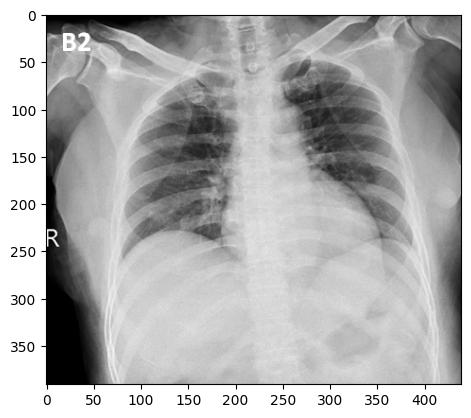

In [ ]:
plt.imshow(cv2.imread("/content/xray_dataset_covid19/train/PNEUMONIA/1-s2.0-S1684118220300682-main.pdf-003-b2.png"))

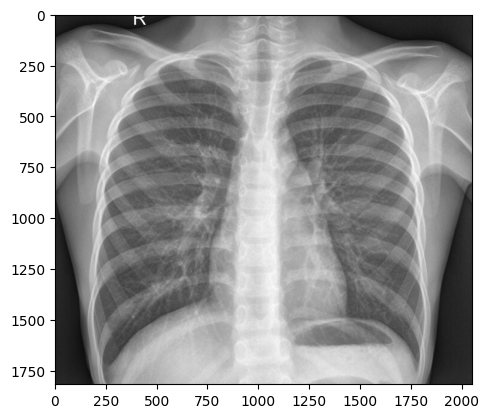

In [ ]:
plt.imshow(cv2.imread("/content/xray_dataset_covid19/train/NORMAL/IM-0007-0001.jpeg"))

In [ ]:
train_datagen=ImageDataGenerator(
    #zoom_range=0.2, #the amount of zooming u need
    horizontal_flip=True, # Make a horizontal copy of image
    rescale=1/255, # Normalize the new images
    width_shift_range=0.10, # The percentage of Width shifitning
    height_shift_range=0.10, # The percentage of height shifitning
    shear_range=0.1, #Shear angle in counter-clockwise direction in degrees
    fill_mode='nearest',
    rotation_range=20,
)
train_generator=train_datagen.flow_from_directory(
    train_dir,
    class_mode='binary',
    color_mode='rgb',
    batch_size= 16,
    target_size=(1000,1000,3)[:2]
)

test_datagen=ImageDataGenerator(rescale=1/255)
test_generator=test_datagen.flow_from_directory(
    test_dir,
    class_mode='binary',
    color_mode='rgb',
    batch_size=16,
    target_size=(1000,1000,3)[:2]
)

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
earlystop=EarlyStopping(patience=6)
learning_rate_reduction=ReduceLROnPlateau(
    monitor='val_acc',
    patience= 3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
model=Sequential()

model.add(Conv2D(32,(2,2),activation='relu',input_shape=(1000,1000,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(2,2),activation='relu'))
model.add(MaxPooling2D(3,3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(3,3))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))

model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam' ,loss='binary_crossentropy',metrics=['accuracy',
                                                                      tf.keras.metrics.AUC(),
                                                                      tf.keras.metrics.Recall(),
                                                                      tf.keras.metrics.Precision(),
                                                                      tf.keras.metrics.FalseNegatives(),
                                                                      tf.keras.metrics.FalsePositives(),
                                                                      tf.keras.metrics.TrueNegatives(),
                                                                      tf.keras.metrics.TruePositives(),
                                                                      tf.keras.metrics.F1Score()])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 999, 999, 32)      416       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 499, 499, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 498, 498, 64)      8256      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 166, 166, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 164, 164, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)       

In [ ]:
model.fit(
    train_generator,
    epochs=14,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/14
10/10 [==============================] - ETA: 0s - loss: 1.4060 - accuracy: 0.5270 - auc: 0.5649 - recall: 0.4189 - precision: 0.5345 - false_negatives: 43.0000 - false_positives: 27.0000 - true_negatives: 47.0000 - true_positives: 31.0000 - f1_score: 0.6667 

10/10 [==============================] - 312s 29s/step - loss: 1.4060 - accuracy: 0.5270 - auc: 0.5649 - recall: 0.4189 - precision: 0.5345 - false_negatives: 43.0000 - false_positives: 27.0000 - true_negatives: 47.0000 - true_positives: 31.0000 - f1_score: 0.6667 - val_loss: 0.6228 - val_accuracy: 0.9250 - val_auc: 1.0000 - val_recall: 0.8500 - val_precision: 1.0000 - val_false_negatives: 3.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 20.0000 - val_true_positives: 17.0000 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 2/14
10/10 [==============================] - ETA: 0s - loss: 0.5457 - accuracy: 0.7703 - auc: 0.8754 - recall: 0.6351 - precision: 0.8704 - false_negatives: 27.0000 - false_positives: 7.0000 - true_negatives: 67.0000 - true_positives: 47.0000 - f1_score: 0.6667 

10/10 [==============================] - 255s 24s/step - loss: 0.5457 - accuracy: 0.7703 - auc: 0.8754 - recall: 0.6351 - precision: 0.8704 - false_negatives: 27.0000 - false_positives: 7.0000 - true_negatives: 67.0000 - true_positives: 47.0000 - f1_score: 0.6667 - val_loss: 0.1812 - val_accuracy: 0.9750 - val_auc: 1.0000 - val_recall: 0.9500 - val_precision: 1.0000 - val_false_negatives: 1.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 20.0000 - val_true_positives: 19.0000 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 3/14
10/10 [==============================] - ETA: 0s - loss: 0.3963 - accuracy: 0.8243 - auc: 0.9060 - recall: 0.7973 - precision: 0.8429 - false_negatives: 15.0000 - false_positives: 11.0000 - true_negatives: 63.0000 - true_positives: 59.0000 - f1_score: 0.6667 

10/10 [==============================] - 260s 28s/step - loss: 0.3963 - accuracy: 0.8243 - auc: 0.9060 - recall: 0.7973 - precision: 0.8429 - false_negatives: 15.0000 - false_positives: 11.0000 - true_negatives: 63.0000 - true_positives: 59.0000 - f1_score: 0.6667 - val_loss: 0.0579 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000 - val_false_negatives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 20.0000 - val_true_positives: 20.0000 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 4/14
10/10 [==============================] - ETA: 0s - loss: 0.3864 - accuracy: 0.8716 - auc: 0.9273 - recall: 0.8784 - precision: 0.8667 - false_negatives: 9.0000 - false_positives: 10.0000 - true_negatives: 64.0000 - true_positives: 65.0000 - f1_score: 0.6667

10/10 [==============================] - 259s 25s/step - loss: 0.3864 - accuracy: 0.8716 - auc: 0.9273 - recall: 0.8784 - precision: 0.8667 - false_negatives: 9.0000 - false_positives: 10.0000 - true_negatives: 64.0000 - true_positives: 65.0000 - f1_score: 0.6667 - val_loss: 0.0537 - val_accuracy: 0.9750 - val_auc: 1.0000 - val_recall: 0.9500 - val_precision: 1.0000 - val_false_negatives: 1.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 20.0000 - val_true_positives: 19.0000 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 5/14
10/10 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.8378 - auc: 0.9207 - recall: 0.7568 - precision: 0.9032 - false_negatives: 18.0000 - false_positives: 6.0000 - true_negatives: 68.0000 - true_positives: 56.0000 - f1_score: 0.6667 

10/10 [==============================] - 268s 29s/step - loss: 0.4147 - accuracy: 0.8378 - auc: 0.9207 - recall: 0.7568 - precision: 0.9032 - false_negatives: 18.0000 - false_positives: 6.0000 - true_negatives: 68.0000 - true_positives: 56.0000 - f1_score: 0.6667 - val_loss: 0.0927 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000 - val_false_negatives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 20.0000 - val_true_positives: 20.0000 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 6/14
10/10 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.8514 - auc: 0.8983 - recall: 0.8919 - precision: 0.8250 - false_negatives: 8.0000 - false_positives: 14.0000 - true_negatives: 60.0000 - true_positives: 66.0000 - f1_score: 0.6667 

10/10 [==============================] - 263s 26s/step - loss: 0.4210 - accuracy: 0.8514 - auc: 0.8983 - recall: 0.8919 - precision: 0.8250 - false_negatives: 8.0000 - false_positives: 14.0000 - true_negatives: 60.0000 - true_positives: 66.0000 - f1_score: 0.6667 - val_loss: 0.0613 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000 - val_false_negatives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 20.0000 - val_true_positives: 20.0000 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 7/14
10/10 [==============================] - ETA: 0s - loss: 0.3916 - accuracy: 0.8378 - auc: 0.9248 - recall: 0.7297 - precision: 0.9310 - false_negatives: 20.0000 - false_positives: 4.0000 - true_negatives: 70.0000 - true_positives: 54.0000 - f1_score: 0.6667 

10/10 [==============================] - 259s 25s/step - loss: 0.3916 - accuracy: 0.8378 - auc: 0.9248 - recall: 0.7297 - precision: 0.9310 - false_negatives: 20.0000 - false_positives: 4.0000 - true_negatives: 70.0000 - true_positives: 54.0000 - f1_score: 0.6667 - val_loss: 0.1005 - val_accuracy: 0.9750 - val_auc: 1.0000 - val_recall: 0.9500 - val_precision: 1.0000 - val_false_negatives: 1.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 20.0000 - val_true_positives: 19.0000 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 8/14
10/10 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.8446 - auc: 0.9251 - recall: 0.8784 - precision: 0.8228 - false_negatives: 9.0000 - false_positives: 14.0000 - true_negatives: 60.0000 - true_positives: 65.0000 - f1_score: 0.6667 

10/10 [==============================] - 258s 25s/step - loss: 0.3455 - accuracy: 0.8446 - auc: 0.9251 - recall: 0.8784 - precision: 0.8228 - false_negatives: 9.0000 - false_positives: 14.0000 - true_negatives: 60.0000 - true_positives: 65.0000 - f1_score: 0.6667 - val_loss: 0.1506 - val_accuracy: 0.9750 - val_auc: 1.0000 - val_recall: 0.9500 - val_precision: 1.0000 - val_false_negatives: 1.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 20.0000 - val_true_positives: 19.0000 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 9/14
10/10 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.9122 - auc: 0.9513 - recall: 0.9189 - precision: 0.9067 - false_negatives: 6.0000 - false_positives: 7.0000 - true_negatives: 67.0000 - true_positives: 68.0000 - f1_score: 0.6667 

10/10 [==============================] - 242s 23s/step - loss: 0.2870 - accuracy: 0.9122 - auc: 0.9513 - recall: 0.9189 - precision: 0.9067 - false_negatives: 6.0000 - false_positives: 7.0000 - true_negatives: 67.0000 - true_positives: 68.0000 - f1_score: 0.6667 - val_loss: 0.1234 - val_accuracy: 0.9750 - val_auc: 1.0000 - val_recall: 0.9500 - val_precision: 1.0000 - val_false_negatives: 1.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 20.0000 - val_true_positives: 19.0000 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 10/14
10/10 [==============================] - ETA: 0s - loss: 0.2651 - accuracy: 0.8649 - auc: 0.9601 - recall: 0.8919 - precision: 0.8462 - false_negatives: 8.0000 - false_positives: 12.0000 - true_negatives: 62.0000 - true_positives: 66.0000 - f1_score: 0.6667 

10/10 [==============================] - 244s 23s/step - loss: 0.2651 - accuracy: 0.8649 - auc: 0.9601 - recall: 0.8919 - precision: 0.8462 - false_negatives: 8.0000 - false_positives: 12.0000 - true_negatives: 62.0000 - true_positives: 66.0000 - f1_score: 0.6667 - val_loss: 0.0590 - val_accuracy: 0.9750 - val_auc: 1.0000 - val_recall: 0.9500 - val_precision: 1.0000 - val_false_negatives: 1.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 20.0000 - val_true_positives: 19.0000 - val_f1_score: 0.6667 - lr: 0.0010


<Axes: >

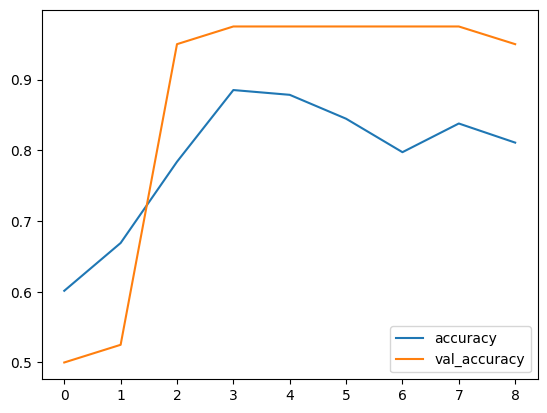

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['accuracy','val_accuracy']].plot()

<Axes: >

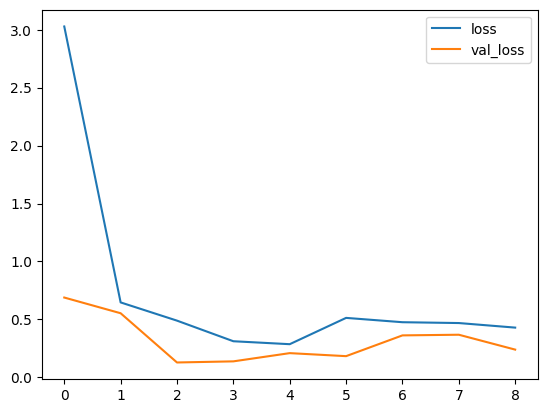

In [ ]:
losses[['loss','val_loss']].plot()

In [ ]:
model.evaluate(test_generator)

3/3 [==============================] - 21s 5s/step - loss: 0.2393 - accuracy: 0.9500


[0.2393307387828827, 0.949999988079071]

In [ ]:
real = test_generator.classes
real

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
predictions = model.predict_generator(test_generator) > 0.5
predictions

array([[ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True]])

Axes(0.1675,0.11;0.5775x0.77)
report :               precision    recall  f1-score   support

           0       0.50      0.55      0.52        20
           1       0.50      0.45      0.47        20

    accuracy                           0.50        40
   macro avg       0.50      0.50      0.50        40
weighted avg       0.50      0.50      0.50        40



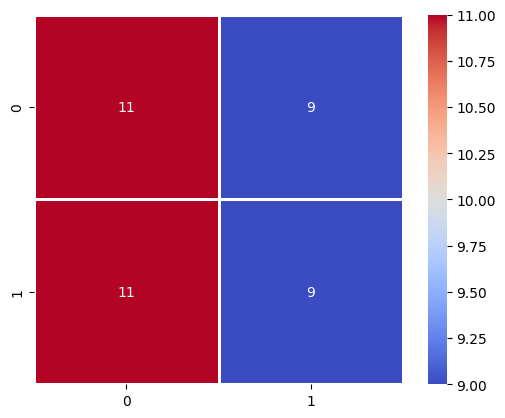

In [ ]:
con = confusion_matrix(real, predictions)
print(sns.heatmap(con,cmap="coolwarm" ,annot=True,fmt="d",linewidths=1 ,square= True))
print('report :',classification_report(real, predictions ))

In [ ]:
predict_path='/content/xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0059-0001.jpeg'
my_image = image.load_img(predict_path,target_size=(1000,1000,3))

In [ ]:
my_image = np.expand_dims(my_image,axis = 0)

In [ ]:
np.argmax(model.predict(my_image))

1/1 [==============================] - 0s 471ms/step


0